In [1]:
library('tidyverse')
library('rvest')
library('lubridate')
options(repr.plot.res = 300, repr.plot.width = 6, repr.plot.height = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
scrape_table = function(i, MF='Women\'s') {
    url = "https://www.baa.org/races/boston-marathon/results/champions"
    webpage = xml2::read_html(url)
    tbl = html_nodes(webpage, "table")[[i]] %>%
        html_table() %>%
        drop_na() %>%
        magrittr::set_colnames(c('year', 'name', 'country', 'time')) %>%
        mutate(time = hms(time)) %>%
        mutate(race.time = as.numeric(time, 'hours')) %>%
        mutate(MF = MF) %>%
        mutate(
            country.simple = ifelse(
                country %in% c('United States', 'Ethiopia', 'Japan', 'Kenya'),
                country,
                'other'
            )
        )
    tbl
}

df.men = scrape_table(1, MF='Men\'s')
df.women = scrape_table(2)

df.marathon = rbind(df.men, df.women)

Let's re-create this chart from FiveThirtyEight

<center>
    <img src="https://fivethirtyeight.com/wp-content/uploads/2018/04/wezerek-marathon-0416-13.png"
         style="width: 600px;"/>
</center>

Preview the data (i.e. `df.marathon`).

In [10]:
df.marathon %>% head

year,name,country,time,race.time,MF,country.simple
<int>,<chr>,<chr>,<Period>,<dbl>,<chr>,<chr>
2019,Lawrence Cherono,Kenya,2H 7M 57S,2.132500,Men's,Kenya
2018,Yuki Kawauchi,Japan,2H 15M 58S,2.266111,Men's,Japan
2017,Geoffrey Kirui,Kenya,2H 9M 37S,2.160278,Men's,Kenya
2016,Lemi Berhanu,Ethiopia,2H 12M 45S,2.212500,Men's,Ethiopia
2015,Lelisa Desisa,Ethiopia,2H 9M 17S,2.154722,Men's,Ethiopia
2014,"Mebrahtom ""Meb"" Keflezighi",United States,2H 8M 37S,2.143611,Men's,United States


In [4]:
library("ggrepel")

In [5]:
label_table = data.frame(
    country.simple = c('United States',
                       'United States',
                        'Kenya',
                        'Kenya',
                        'Ethiopia',
                        'Japan'),
    MF = c("Men's", "Women's", "Men's", "Women's", "Women's", "Men's"),
    year = c(1915, 1975, 1990, 2010, 1995, 1955),
    race.time = c(2.75, 3, 2, 2.25, 2.5, 2.25) 
)
label_table

country.simple,MF,year,race.time
<chr>,<chr>,<dbl>,<dbl>
United States,Men's,1915,2.75
United States,Women's,1975,3.00
Kenya,Men's,1990,2.00
Kenya,Women's,2010,2.25
Ethiopia,Women's,1995,2.50
Japan,Men's,1955,2.25


Fill in the table below:

| chart property | column name |
| --- | --- |
| x value | year |
| y value | ? |
| color | ? |
| facet value | ? |

Make note of other aesthetic decisions. 
- What's the y-axis title?
- Do the two charts share the same x-axis bounds?
- Is there a legend?

Code your version of the chart below.

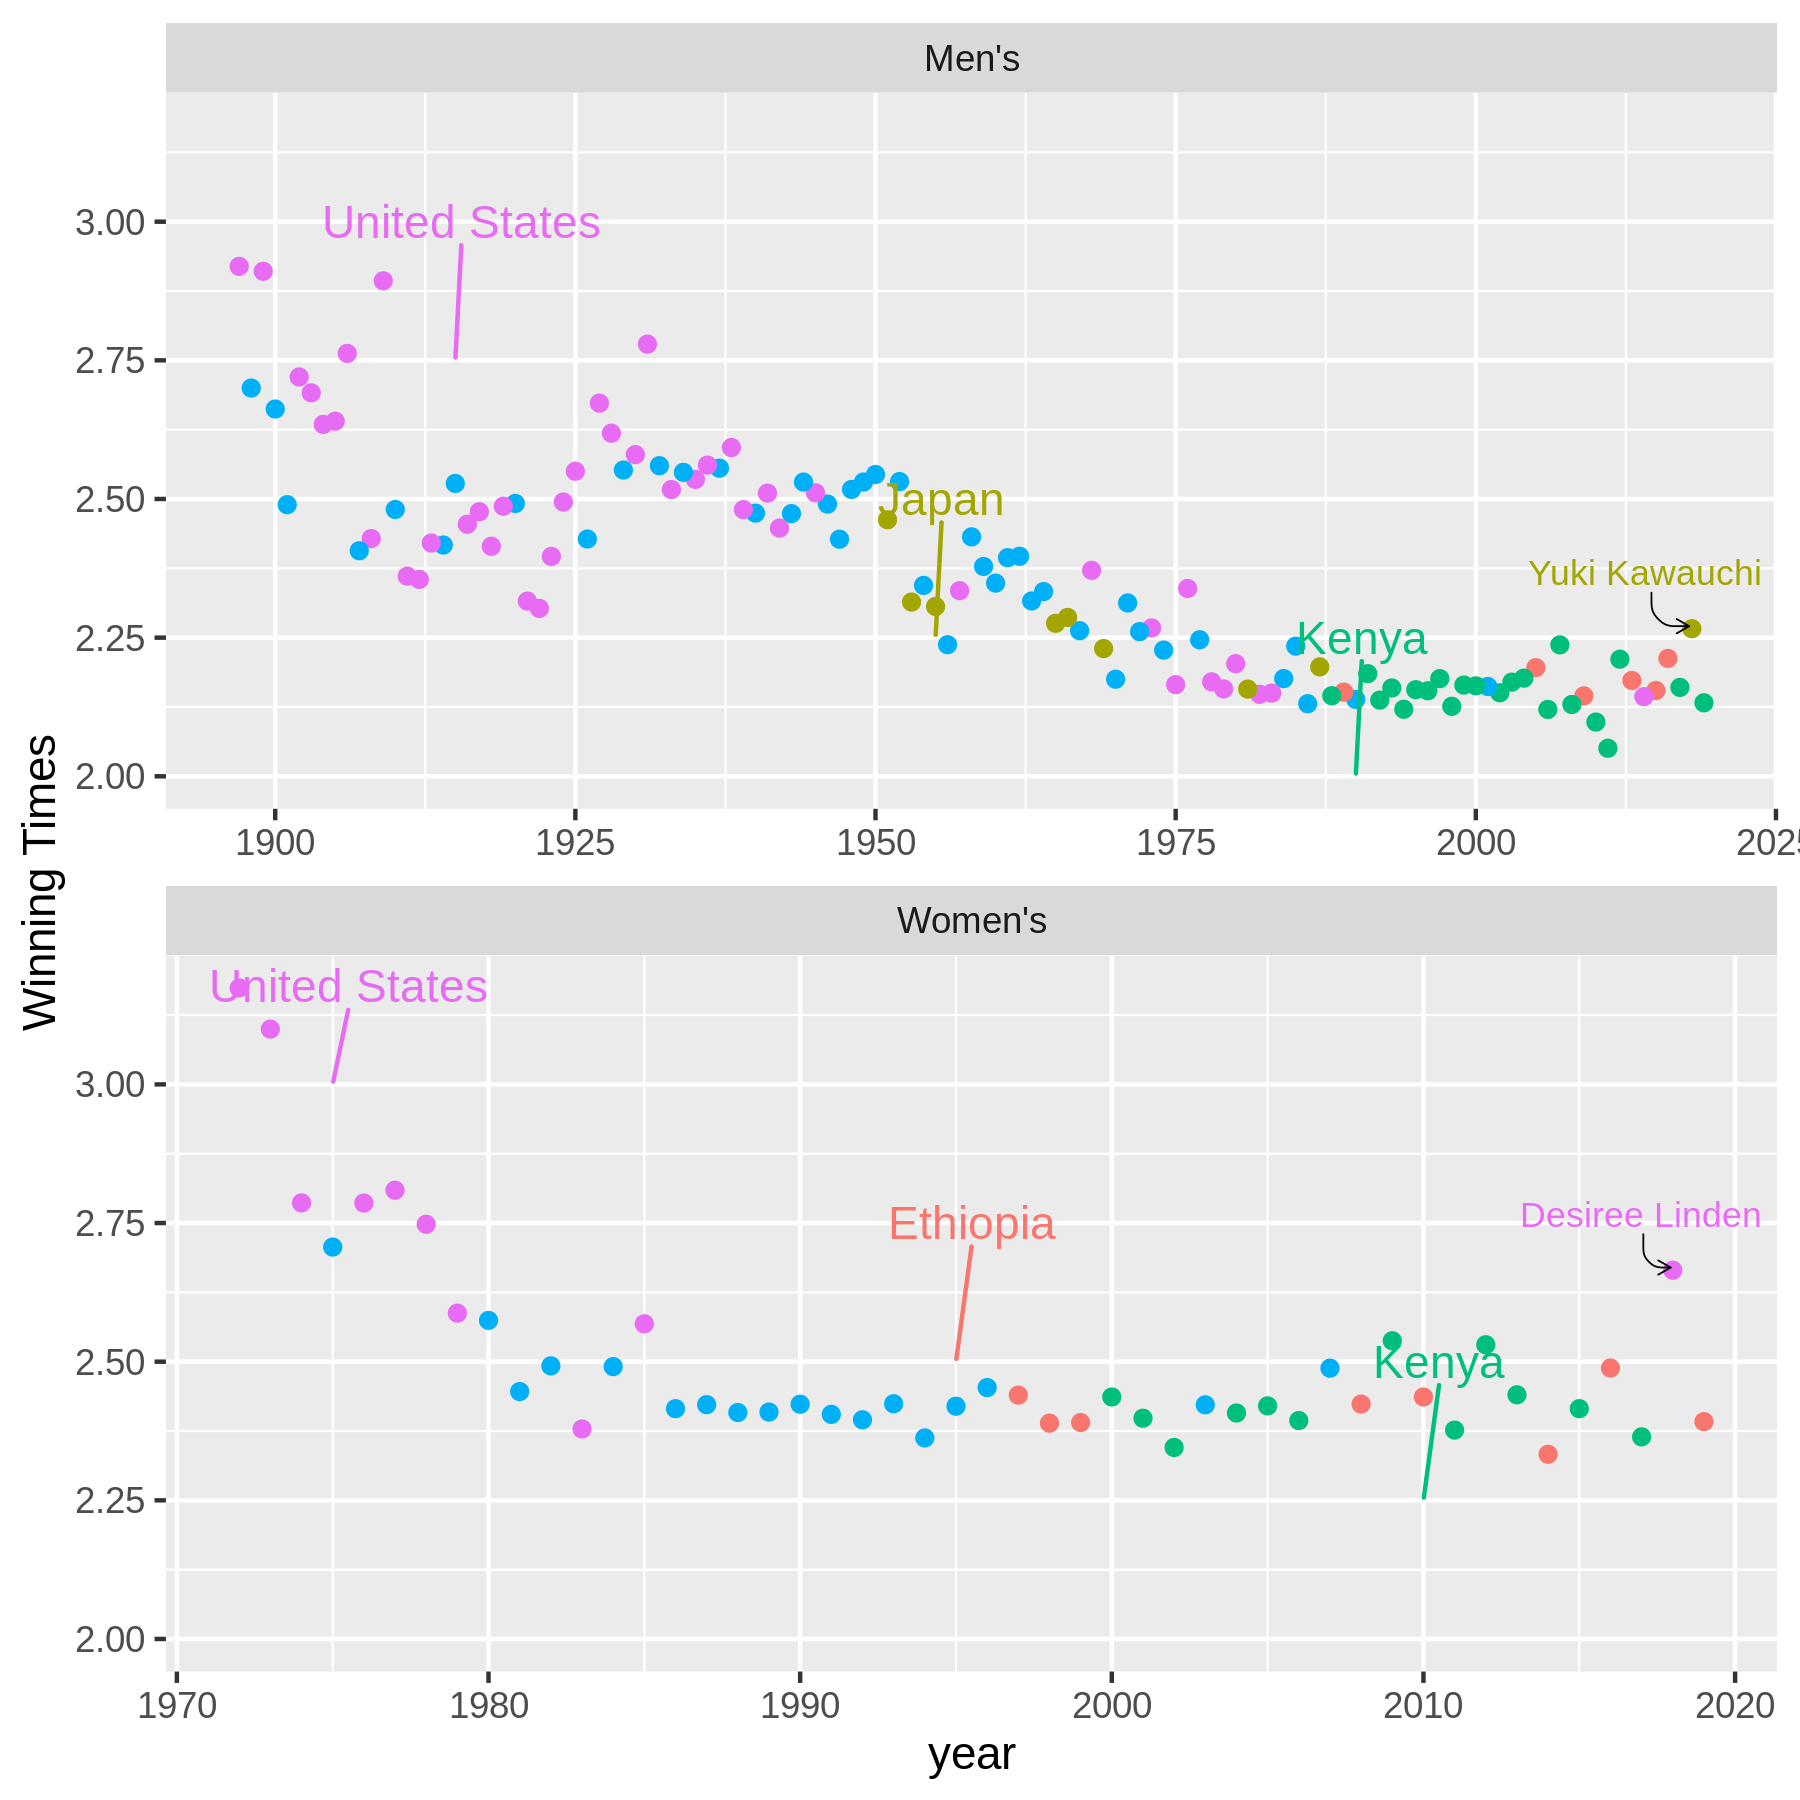

In [7]:
p = ggplot(df.marathon, aes(y = race.time, x = year,  color = country.simple, label = name))
p = p + geom_point()
p = p + facet_wrap(~MF, ncol=1, scales = "free_x")
p = p + geom_text_repel(data = df.marathon %>% filter (year == 2018), 
                       nudge_y = 0.1, 
                       segment.size = 0.2, 
                       size = 3, 
                       segment.color = "black",
                       segment.curvature = 0.667,
                       segment.ncp = 2,
                       arrow = arrow(length = unit(0.02, "npc")))
p = p + geom_text_repel(data = label_table, mapping = aes(label=country.simple), nudge_y = 0.25, nudge_x =0.5)
p = p + theme(legend.position = 'none')
p = p + labs(y = 'Winning Times')
p

What else might you visualize with this data? (e.g. What about totaling the winners from each country?)

In [8]:
df.marathon %>%
    group_by(MF, country.simple) %>%
summarize(rt_mean = mean(race.time), year_mean = mean(year))
df.marathon

`summarise()` has grouped output by 'MF'. You can override using the `.groups` argument.



MF,country.simple,rt_mean,year_mean
<chr>,<chr>,<dbl>,<dbl>
Men's,Ethiopia,2.172083,2007.833
Men's,Japan,2.277315,1971.667
Men's,Kenya,2.151086,2001.909
Men's,other,2.401118,1948.952
Men's,United States,2.474678,1935.091
Women's,Ethiopia,2.411597,2007.625
Women's,Kenya,2.422199,2007.917
Women's,other,2.453333,1989.611
Women's,United States,2.760250,1981.500


year,name,country,time,race.time,MF,country.simple
<int>,<chr>,<chr>,<Period>,<dbl>,<chr>,<chr>
2019,Lawrence Cherono,Kenya,2H 7M 57S,2.132500,Men's,Kenya
2018,Yuki Kawauchi,Japan,2H 15M 58S,2.266111,Men's,Japan
2017,Geoffrey Kirui,Kenya,2H 9M 37S,2.160278,Men's,Kenya
2016,Lemi Berhanu,Ethiopia,2H 12M 45S,2.212500,Men's,Ethiopia
2015,Lelisa Desisa,Ethiopia,2H 9M 17S,2.154722,Men's,Ethiopia
2014,"Mebrahtom ""Meb"" Keflezighi",United States,2H 8M 37S,2.143611,Men's,United States
2013,Lelisa Desisa,Ethiopia,2H 10M 22S,2.172778,Men's,Ethiopia
2012,Wesley Korir,Kenya,2H 12M 40S,2.211111,Men's,Kenya
2011,Geoffrey Mutai,Kenya,2H 3M 2S,2.050556,Men's,Kenya
